In [55]:
# Load packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

In [56]:
# Device configuration
print(torch.__version__) 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
#device = torch.device('cuda:0')
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))

1.12.1
True
NVIDIA GeForce RTX 2060
1
0


In [57]:
batch_size = 1
data_dir = 'fishes'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [58]:
# Define transforms for the training, validation, and testing sets
training_transforms = transforms.Compose([transforms.RandomRotation(30),
                                          transforms.RandomResizedCrop(224),  #224
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406], 
                                                               [0.229, 0.224, 0.225])])

validation_transforms = transforms.Compose([transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize([0.485, 0.456, 0.406], 
                                                                 [0.229, 0.224, 0.225])])

testing_transforms = transforms.Compose([transforms.Resize(256),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], 
                                                              [0.229, 0.224, 0.225])])

# TODO: Load the datasets with ImageFolder
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(valid_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

# TODO: Using the image datasets and the trainforms, define the dataloaders
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)  # batch_size=64
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size)           # batch_size=32
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size)                  # batch_size=32

classes = ('Black Sea Sprat', 'Gilt-Head Bream', 'Hourse Mackerel', 'Red Mullet', 'Red Sea Bream', 'Sea Bass','Shrimp','Striped Red Mullet', 'Trout')

In [59]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #3 color channels
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*53*53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 9) #9 classes


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x =x.view(-1, 16*53*53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [60]:
# Inference
PATH = './savednetwork/cnn2.pth'
PATH2 = './fish-g620be2538_1920.jpg'


model = torch.load(PATH)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=9, bias=True)
)

In [61]:
# Inference2
# Performance evaluation (Test dataset)
print('Test dataset accuracy')
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(9)]
    n_class_samples = [0 for i in range(9)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)


        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted ==labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0*n_correct/ n_samples
    print(f'Accuracy of the network: {acc} %')


    for i in range(9):
        acc = 100.0*n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

# Performance evaluation (Validate dataset)
print('Validate dataset accuracy')
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(9)]
    n_class_samples = [0 for i in range(9)]
    for images, labels in validate_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)


        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted ==labels).sum().item()

        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0*n_correct/ n_samples
    print(f'Accuracy of the network: {acc} %')


    for i in range(9):
        acc = 100.0*n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')

Test dataset accuracy
Accuracy of the network: 79.22222222222223 %
Accuracy of Black Sea Sprat: 78.5 %
Accuracy of Gilt-Head Bream: 67.5 %
Accuracy of Hourse Mackerel: 54.5 %
Accuracy of Red Mullet: 83.0 %
Accuracy of Red Sea Bream: 91.0 %
Accuracy of Sea Bass: 95.0 %
Accuracy of Shrimp: 100.0 %
Accuracy of Striped Red Mullet: 58.0 %
Accuracy of Trout: 85.5 %
Validate dataset accuracy
Accuracy of the network: 82.66666666666667 %
Accuracy of Black Sea Sprat: 85.0 %
Accuracy of Gilt-Head Bream: 75.5 %
Accuracy of Hourse Mackerel: 76.5 %
Accuracy of Red Mullet: 95.0 %
Accuracy of Red Sea Bream: 82.0 %
Accuracy of Sea Bass: 94.5 %
Accuracy of Shrimp: 100.0 %
Accuracy of Striped Red Mullet: 87.0 %
Accuracy of Trout: 48.5 %


In [62]:
from PIL import Image

def process_image(image_path):
    pil_image = Image.open(image_path)

    # Resize
    if pil_image.size[0] > pil_image.size[1]:
        pil_image.thumbnail((5000, 256))
    else:
        pil_image.thumbnail((256, 5000))

    # Crop
    left_margin = (pil_image.width - 224)/2
    bottom_margin = (pil_image.height - 224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224

    left_margin = (pil_image.width - 224)/2
    pil_image = pil_image.crop((left_margin, bottom_margin, right_margin, top_margin))

    # Normalize
    np_image = np.array(pil_image)/255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std

    np_image = np_image.transpose((2, 0, 1))

    return np_image

<AxesSubplot:>

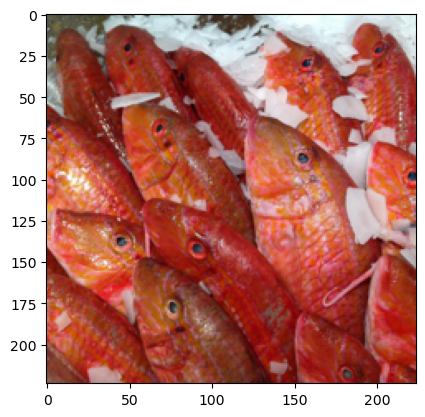

In [63]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()


    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std*image + mean

    if title is not None:
        ax.set_title(title)

    image = np.clip(image, 0 ,1)

    ax.imshow(image)

    return ax

image = process_image(PATH2)
imshow(image)

In [64]:
def predict(image_path, model, topk = 9):
    image = process_image(image_path)
    image = torch.from_numpy(image).type(torch.cuda.FloatTensor)
    image = image.unsqueeze(0)
    output = model.forward(image)
    probabilities = torch.exp(output)



    top_probabilities, top_indices = probabilities.topk(topk)

    

    top_probabilities = top_probabilities.detach().type(torch.FloatTensor).numpy().tolist()[0]
    top_indices = top_indices.detach().type(torch.FloatTensor).numpy().tolist()[0]
    #idx_to_class = {value: key for key, value in model.class_to_idx.items()}
    #top_classes = [idx_to_class[index] for index in top_indices]

    summ = sum(top_probabilities)

    top_probabilities = np.divide(top_probabilities,summ)
    top_indices = map(int, top_indices)
    top_indices = list(top_indices)
    top_indices = map(str, top_indices)
    top_indices = list(top_indices)



    return top_probabilities, top_indices


probs, indices = predict(PATH2, model)
print(probs)
print(indices)

[9.99999999e-01 1.24720914e-09 3.54933202e-15 1.51413153e-17
 1.00664134e-20 2.05970478e-21 6.46809165e-25 2.28198740e-26
 9.12461523e-30]
['3', '7', '5', '1', '2', '0', '8', '4', '6']


In [65]:
import json

with open('fish_to_name.json', 'r') as f:
    fish_to_name = json.load(f)

print(len(fish_to_name))
print(fish_to_name)

9
{'0': 'Black Sea Sprat', '1': 'Gilt-Head Bream', '2': 'Hourse Mackerel', '3': 'Red Mullet', '4': 'Red Sea Bream', '5': 'Sea Bass', '6': 'Shrimp', '7': 'Striped Red Mullet', '8': 'Trout'}


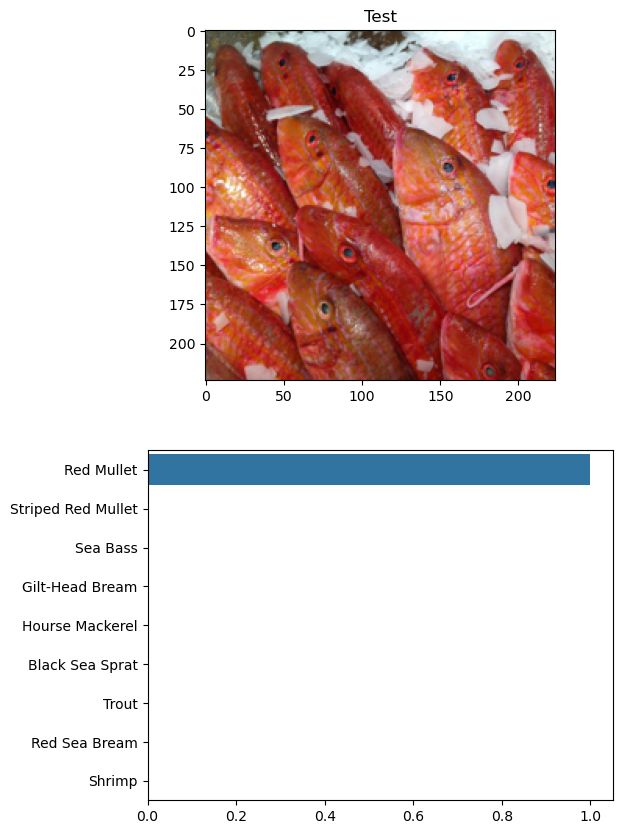

In [66]:
plt.figure(figsize = (6, 10))
plot_1 = plt.subplot(2, 1, 1)


fish_names = [fish_to_name[i] for i in indices]
#print(fish_names)
#print(fish_to_name['1'] )

imshow(image, plot_1, title = 'Test')

plt.subplot(2,1,2)

sb.barplot(x=probs, y = fish_names, color = sb.color_palette()[0])
plt.show()